In [35]:
from pygeoinf.interval.function_providers import NormalModesProvider, BumpFunctionProvider, SineFunctionProvider
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval.l2_space import L2Space
from pygeoinf.hilbert_space import EuclideanSpace
from pygeoinf.interval.operators import SOLAOperator
from pygeoinf.interval.functions import Function
from pygeoinf.gaussian_measure import GaussianMeasure
import matplotlib.pyplot as plt
import numpy as np
from pygeoinf.interval.boundary_conditions import BoundaryConditions
from pygeoinf.interval.operators import LaplacianInverseOperator
from pygeoinf.forward_problem import LinearForwardProblem
from pygeoinf.linear_bayesian import LinearBayesianInference
from pygeoinf.linear_solvers import CholeskySolver
from pygeoinf.interval.providers import BasisProvider
# Set-up folder for saving figures
import os
figures_folder = 'pli_figures'
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

In [36]:
# Create a function domain and spaces
function_domain = IntervalDomain(0, 1)
# We instantiate a space with no basis because we want to add a custom basis later.
N = 10 # Number of basis fuctions, even though we have not decided yet which will be those basis functions
M = L2Space(N, function_domain, basis_type='none')
# Then we select a function provider that gives us Sine functions as eigenfunctions of the negative laplacian operator
function_provider = SineFunctionProvider(M)
# We use this function provider to form the basis provider
basis_provider = BasisProvider(M, function_provider, orthonormal=True, basis_type='Sine')
# Now we set this basis provider as that of our space and then our space will officially have a basis
M.set_basis_provider(basis_provider)

Basis provider set successfully. Space now has 10 basis functions of type 'Sine'.


In [37]:
bcs = BoundaryConditions(bc_type='dirichlet', left=0, right=0)

In [38]:
from pygeoinf.interval.fem_solvers import GeneralFEMSolver
solver = GeneralFEMSolver(M, bcs)
solver.setup()

Setting up GeneralFEMSolver with 10 basis functions from BasisProvider


In [39]:
for i in range(M.dim):
            phi_i = M.get_basis_function(i)
            for j in range(i, M.dim):  # Exploit symmetry
                # Integrate φ'ᵢ * φ'ⱼ using Function operations
                phi_j = M.get_basis_function(j)
                integrand = phi_i * phi_j
                integral = integrand.integrate()

In [40]:

laplacian = LaplacianInverseOperator(M, bcs, fem_type='general')

Setting up GeneralFEMSolver with 10 basis functions from BasisProvider
LaplacianInverseOperator initialized with general FEM solver, dirichlet(left=0, right=0) BCs


In [41]:
f = Function(M, evaluate_callable=lambda x: x**2)
s = Function(M, evaluate_callable=lambda x: x * (1 - x**3) / 12)

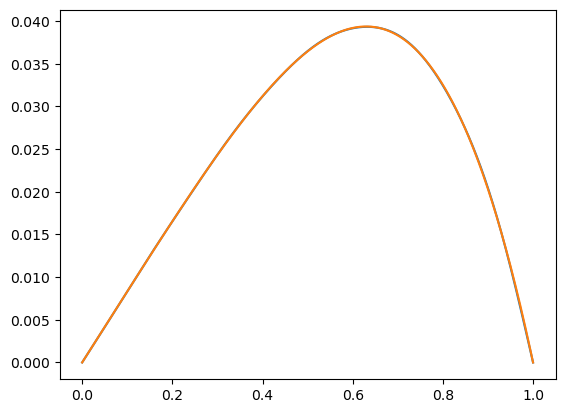

In [42]:
x = function_domain.uniform_mesh(1000)
plt.plot(x, laplacian(f).evaluate(x))
plt.plot(x, s.evaluate(x))